In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_folder='experiments'

## Plot loss/mean AUC for folder with logs

In [14]:
#input - file in format #epoch, #batch, loss or accuracy
#output - numpy array of mean value per epoch
def extract_data(filename):
    f=open(filename,'r')
    values=list(map(lambda x: x.split('\t'),f.read().split('\n')))[:-1]
    values=list(map(lambda x: list(map(lambda y: float(y),x)),values))
    values=np.array(values)
    epoch_prev=1.0
    epoch_input=[]
    inputs=[]
    for epoch,input in zip(values[:,0],values[:,2]):
        if epoch_prev==epoch:
            epoch_input.append(input)
        else:
            inputs.append(np.array(epoch_input).mean())
            epoch_input=[]
        epoch_prev=epoch
    inputs.append(np.array(epoch_input).mean())
    f.close()
    return (np.array(inputs)),values

def plot_plain_graph(filename,title='',xlabel='',ylabel=''):
    inputs,_=extract_data(filename)
    plt.plot(inputs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#print all log files with experiments of numbers in list
def folder_plot(folder,list_of_nums):
    for i in list_of_nums:
        for value in ['loss','auc']:
            fig,ax=plt.subplots(figsize=(10,10))
            for j,name in enumerate(['train','test']):
                filename='_'.join([str(i),'log',name,value])
                filename+='.txt'

                inputs,_=extract_data(os.path.join(folder,filename)) 
                ax.plot(inputs,label=name)
                print('Experiment #',str(i),name,' ',value,' is ',round(inputs[-1],2))
            ax.set_title('Experiment #'+str(i)+', '+value,fontsize=20)
            ax.set_xlabel('#epoch',fontsize=20)
            ax.set_ylabel(value,fontsize=20)
            ax.legend(fontsize=20)
            

Experiment # 2 train   loss  is  0.07
Experiment # 2 test   loss  is  0.26
Experiment # 2 train   auc  is  0.85
Experiment # 2 test   auc  is  0.63
Experiment # 3 train   loss  is  0.14
Experiment # 3 test   loss  is  0.19
Experiment # 3 train   auc  is  0.66
Experiment # 3 test   auc  is  0.63
Experiment # 4 train   loss  is  0.09
Experiment # 4 test   loss  is  0.2
Experiment # 4 train   auc  is  0.67
Experiment # 4 test   auc  is  0.64
Experiment # 5 train   loss  is  0.15
Experiment # 5 test   loss  is  0.18
Experiment # 5 train   auc  is  0.65
Experiment # 5 test   auc  is  0.63
Experiment # 6 train   loss  is  0.18
Experiment # 6 test   loss  is  0.19
Experiment # 6 train   auc  is  0.58
Experiment # 6 test   auc  is  0.58


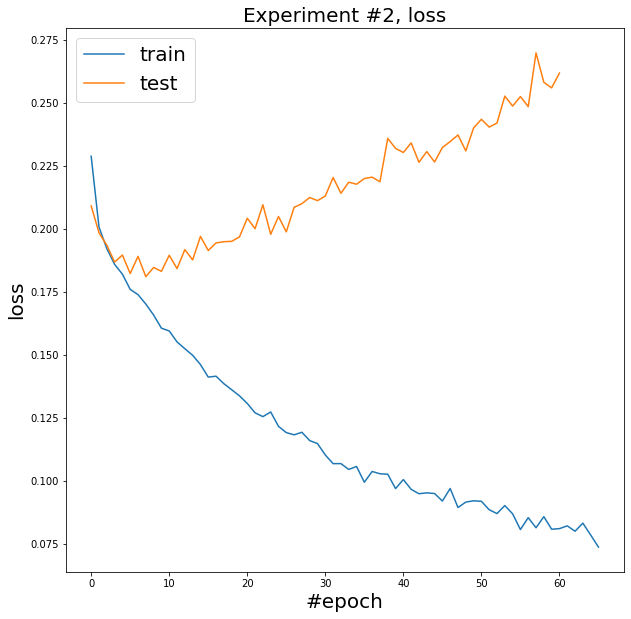

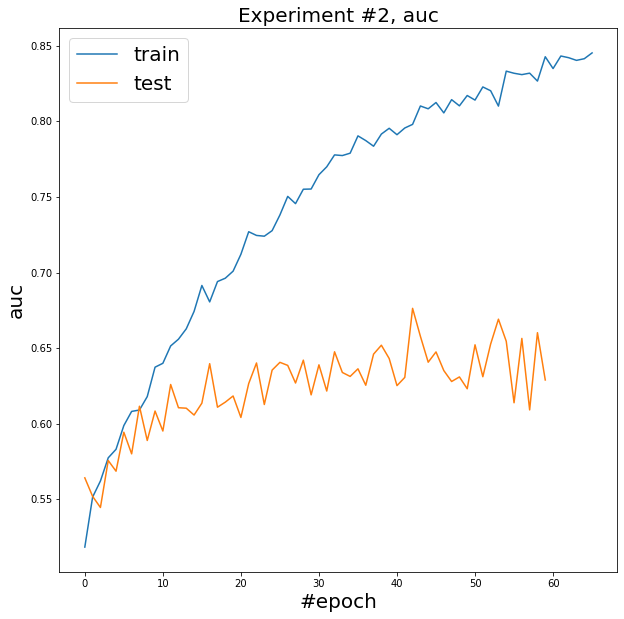

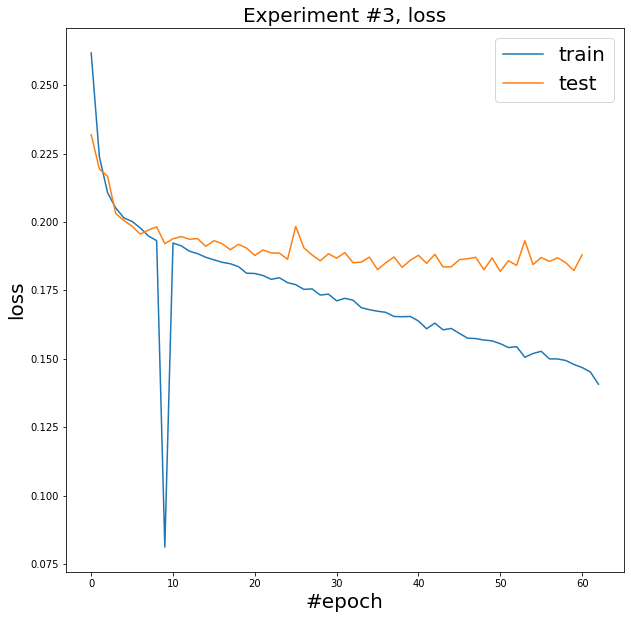

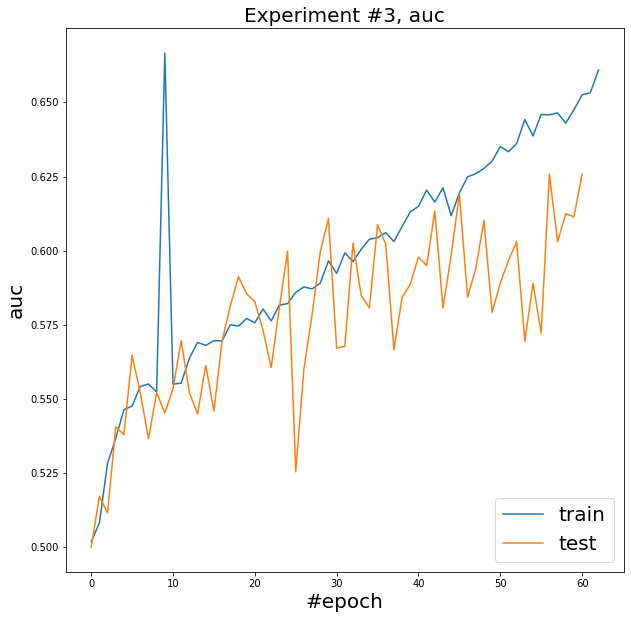

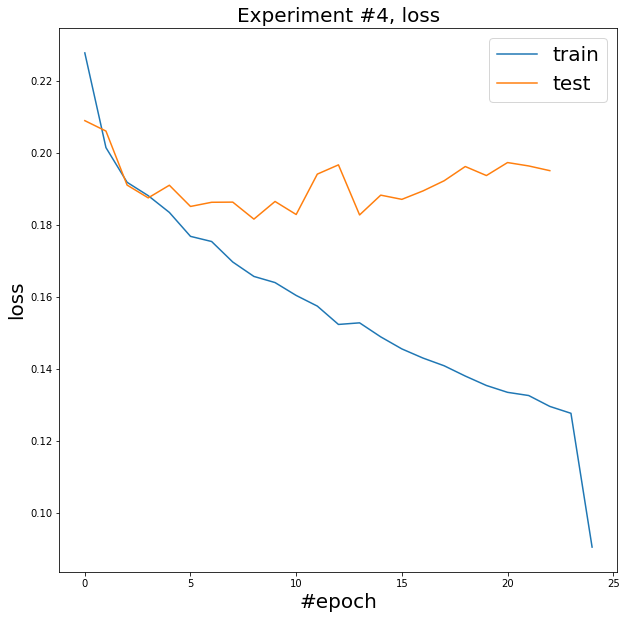

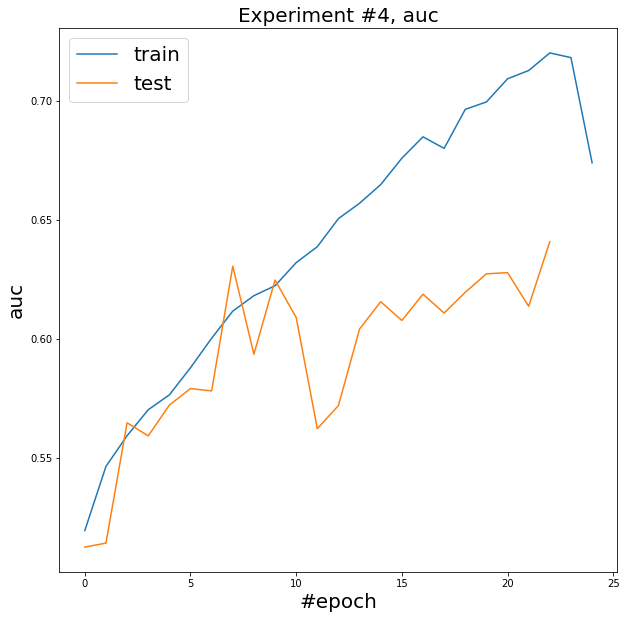

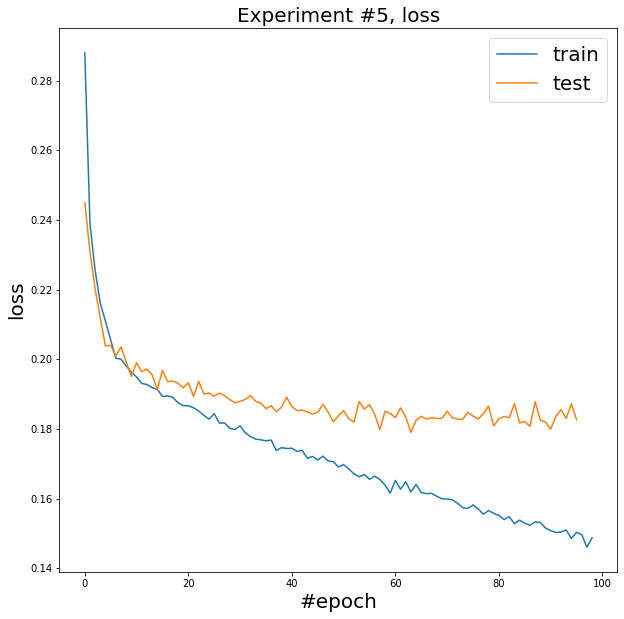

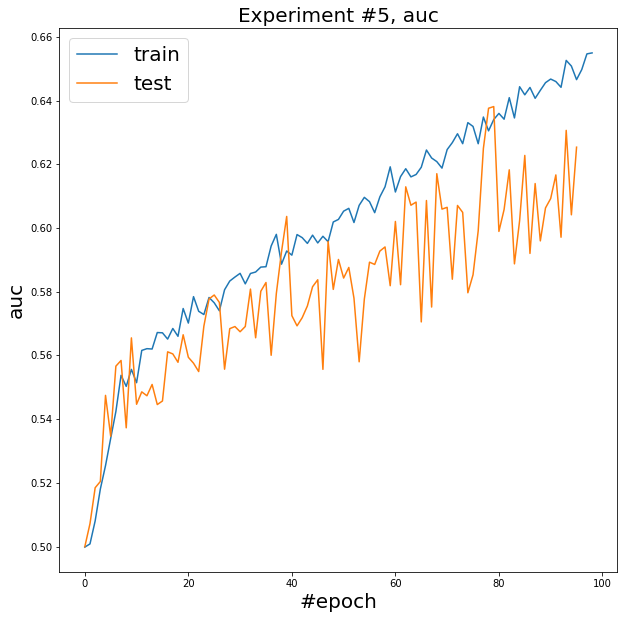

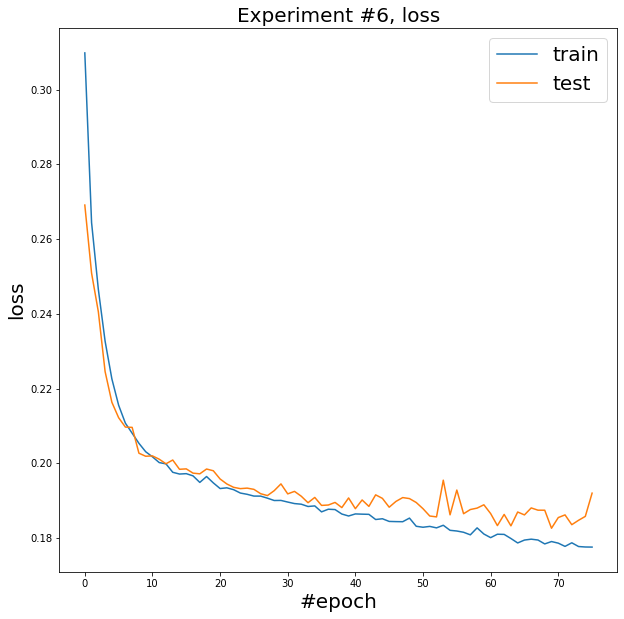

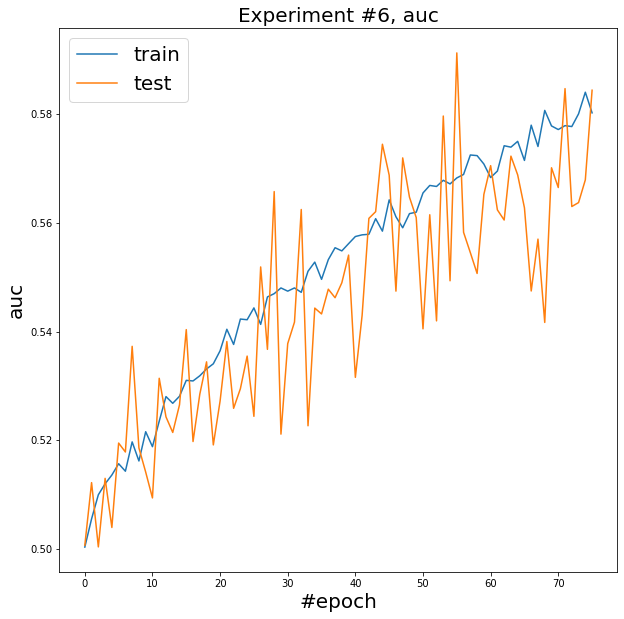

In [15]:
folder_plot(data_folder,list(range(2,7)))

Experiment # 5 train   loss  is  0.15
Experiment # 5 test   loss  is  0.18
Experiment # 5 train   auc  is  0.65
Experiment # 5 test   auc  is  0.63
Experiment # 6 train   loss  is  0.18
Experiment # 6 test   loss  is  0.19
Experiment # 6 train   auc  is  0.58
Experiment # 6 test   auc  is  0.58


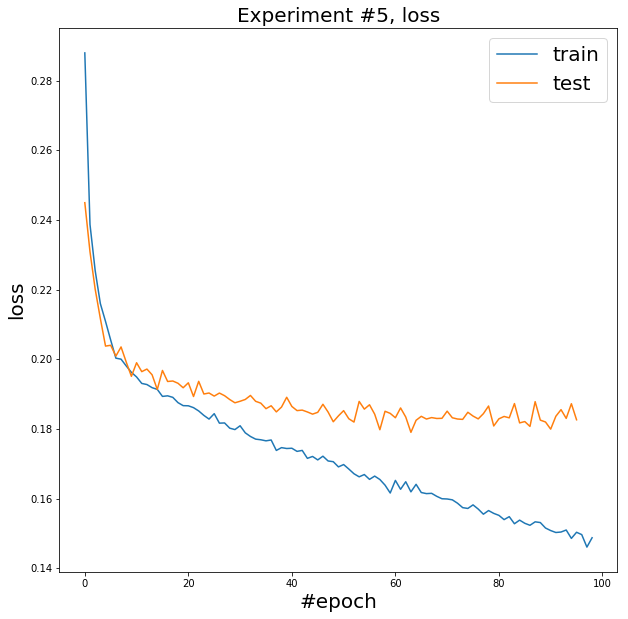

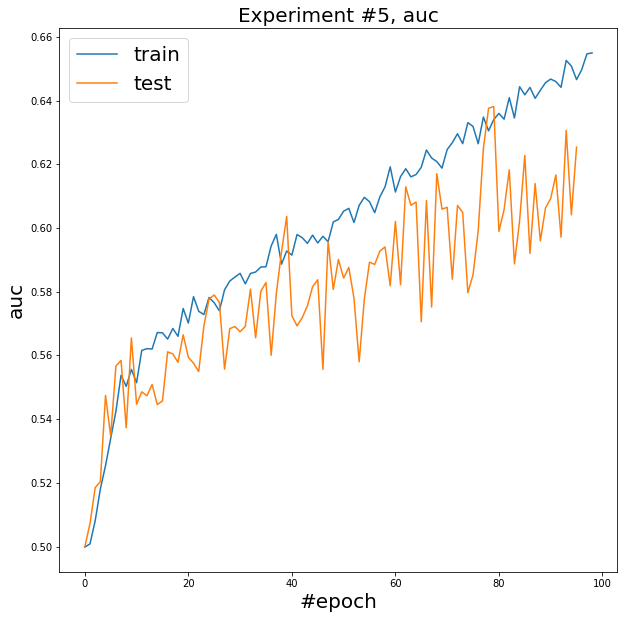

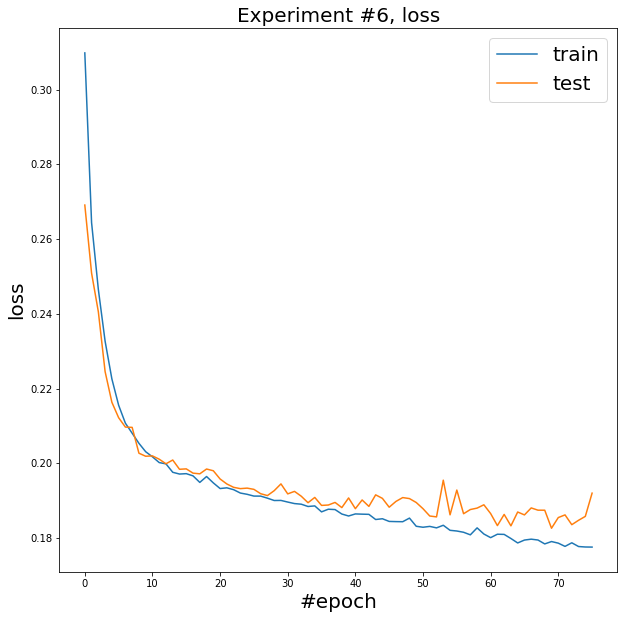

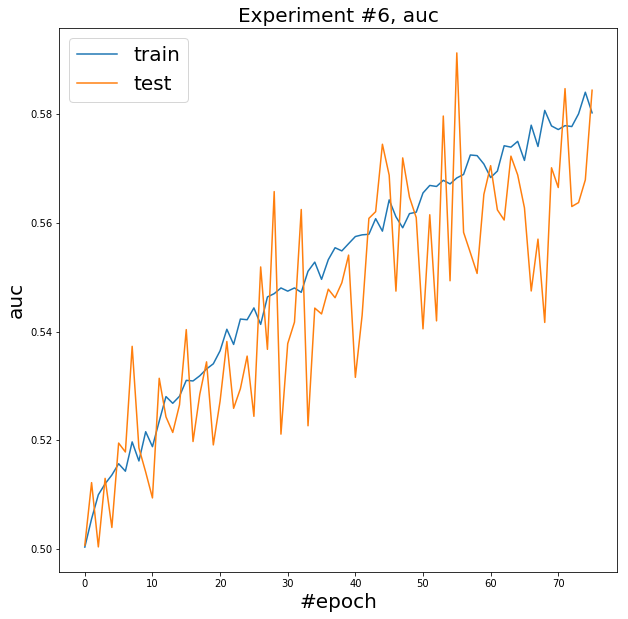

In [49]:
folder_plot(data_folder,range(5,7))

## Plot AUCs for different channels

In [30]:
#create array aucs number of channels*number of epochs (mean value of auc per channel per epoch)
def extract_data_channels(filename):
    with open(filename,'r') as f:
        values=list(map(lambda x: x.split('\t'),f.read().split('\n')))[:-1]
    values=list(map(lambda x: list(map(lambda y: float(y),x)),values))
    values=np.array(values)
    aucs=np.zeros(shape=(12,int(np.max(values[:,0]))))

    for p in range(12):
        one_aucs=values[np.where(values[:,2]==p)][:,[0,3]]
        for epoch in range(int(np.max(values[:,0]))):
            one_aucs_epoch=one_aucs[np.where(one_aucs[:,0]==epoch)][:,1].mean()
            aucs[p][epoch]=one_aucs_epoch
    return aucs[:,1:]

def channels_plot(filename,dataname='../MultiTox/database/data/tox21_10k_data_all_no_salts.csv',experiment_num=None,label=None,smooth=None):
    
    aucs = extract_data_channels(filename)
    for j,auc in enumerate(aucs):
        aucs[j][np.where(aucs[j]!=aucs[j])]=(np.mean(aucs[j][np.where(aucs[j]==aucs[j])]))
    epochs = np.arange(1,aucs.shape[1]+1)
    if smooth is not None and aucs.shape[1]>2*smooth:
        N = aucs.shape[1]//smooth
        aucs=aucs[:,:N*smooth]
        aucs = np.mean(aucs.reshape(aucs.shape[0],N, smooth),axis = 2)
        epochs=np.arange(1,aucs.shape[1]+1)*smooth
        
    data=pd.read_csv(dataname)
    props=list(data)
    try:
        props.remove('smiles_no_salt')
    except:
        pass

    NUM_COLORS = 12

    cm = plt.get_cmap('tab20')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    for i,auc in enumerate(aucs):
        ax.plot(epochs,(auc),label=props[i]+', '+str(round(np.count_nonzero(data[props[i]])/(len(data[props[i]])-np.count_nonzero(data[props[i]])),1)))
        if props[i]=='SR-ATAD5':
            x = epochs[-1]
            y = auc[-1]+i/5000
        elif props[i]=='NR-PPAR-gamma':
            x = epochs[-1]
            y = auc[-1]-i/5000
        else:
            x = epochs[-1]
            y = auc[-1]
        print(props[i], auc[-1])
#         ax.set_yscale('log')  
#         ax.text(x = x,y = y, s=props[i])
    ax.set_ylim(0.49,0.82)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('AUC',fontsize=20)
    ax.set_xlabel('#epoch',fontsize=20)
    if experiment_num is not None and label is not None:
        ax.set_title('Experiment #'+str(experiment_num)+', '+label,fontsize=20)
    plt.legend(fontsize=13)
    print(aucs[:,-1].mean())
    
def folder_plot_channels(folder,list_of_nums,smooth=None):
    for i in list_of_nums:
        value = 'loss'
        fig,ax=plt.subplots(figsize=(10,15))
        for j,name in enumerate(['train','test']):
            filename='_'.join([str(i),'log',name,value])
            filename+='.txt'
            try:
                inputs,_=extract_data(os.path.join(folder,filename)) 
                
                ax.plot(inputs,label=name)
                print('Experiment #',str(i),name,' ',value,' is ',round(inputs[-1],2))

            except FileNotFoundError:
                pass
        ax.set_title('Experiment #'+str(i)+', '+value,fontsize=20)
        ax.set_xlabel('#epoch',fontsize=20)
        ax.set_ylabel(value,fontsize=20)
        ax.legend(fontsize=20)
        value = 'auc'
        for j,name in enumerate(['train','test']):
            filename='_'.join([str(i),'log',name,value])
            filename+='.txt'
            try:
                channels_plot(os.path.join(folder,filename),experiment_num=i,label=name,smooth=smooth)
            except FileNotFoundError:
                pass
            

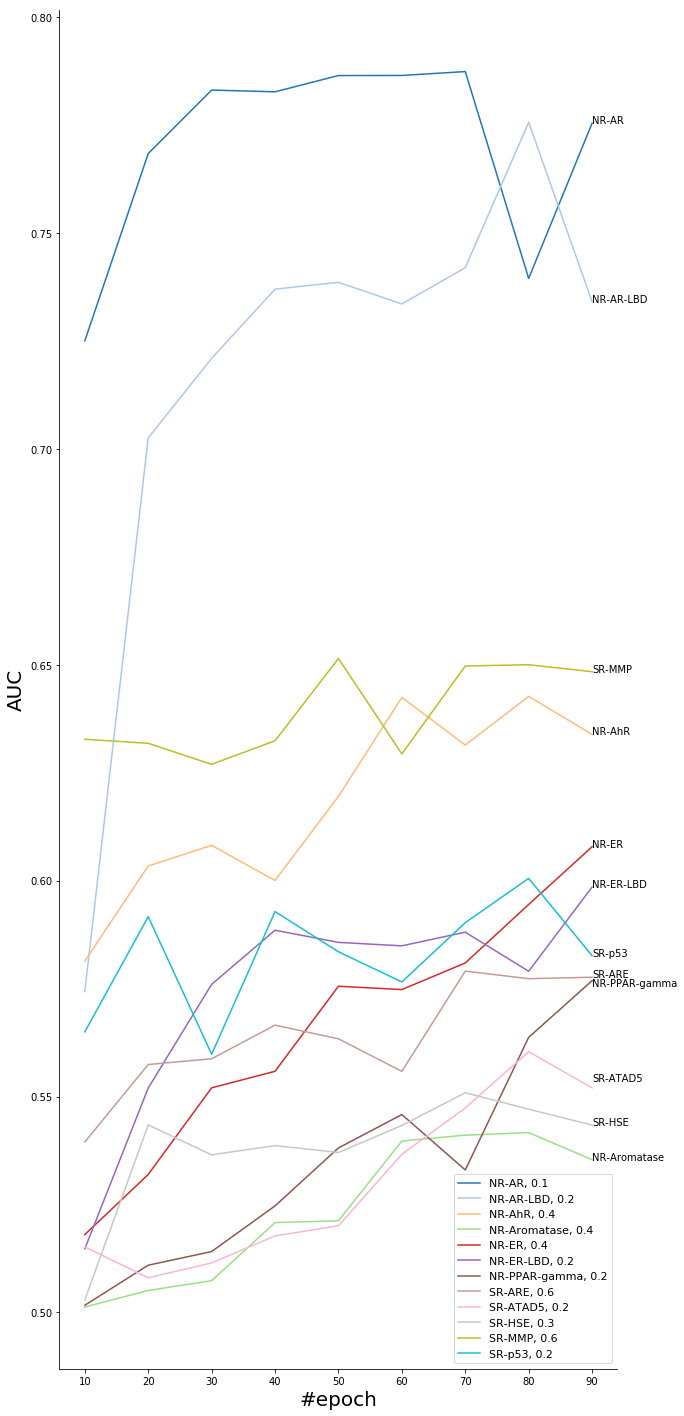

In [14]:
channels_plot('log_test_auc.txt',smooth=10)


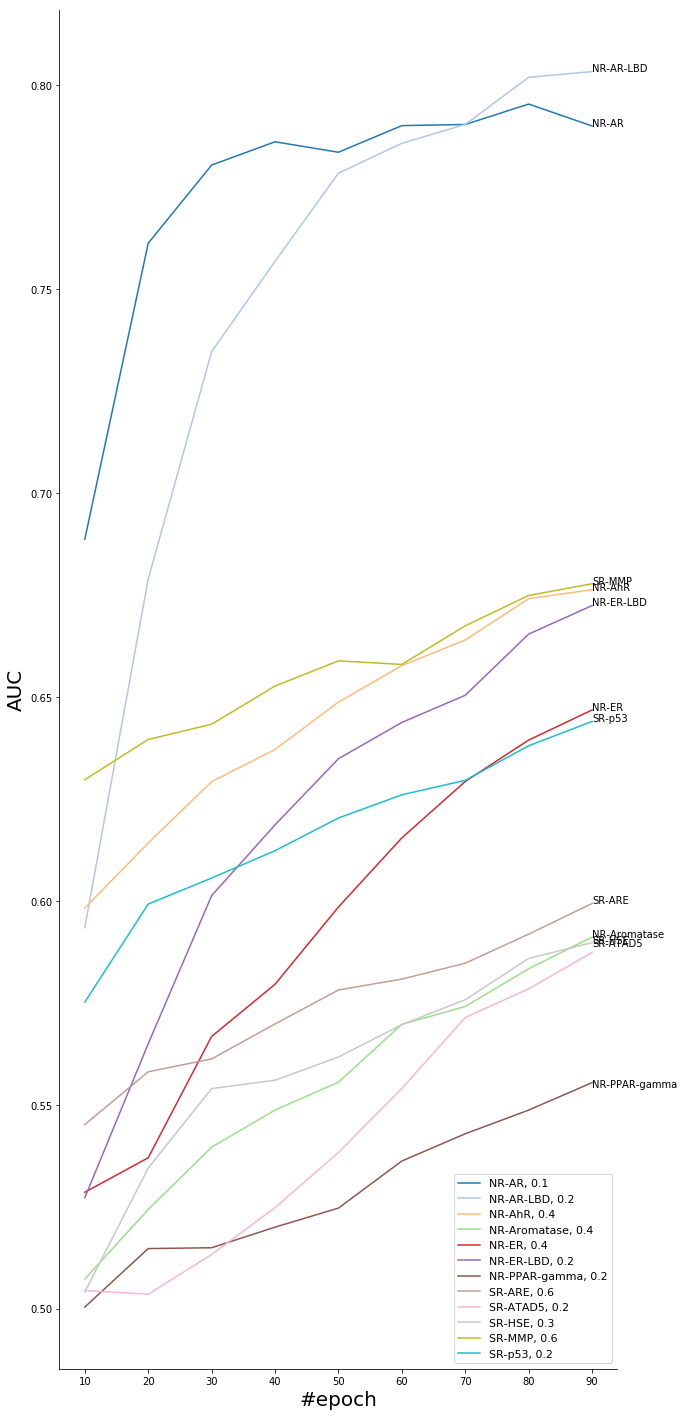

In [15]:
channels_plot('log_train_auc.txt',smooth = 10)

In [130]:
import torch

In [41]:
f = open('log_test_loss.txt','r').read().split('\n')


In [42]:
f = list(map(lambda x: x.split('\t'),f))

Experiment # 10 train   loss  is  0.1
Experiment # 10 test   loss  is  0.14
NR-AR 0.8355937506488571
NR-AR-LBD 0.8575514336534814
NR-AhR 0.7771152459899437
NR-Aromatase 0.7000521952866074
NR-ER 0.7505790295593278
NR-ER-LBD 0.8079409816895909
NR-PPAR-gamma 0.6488021751031194
SR-ARE 0.6953468959435036
SR-ATAD5 0.7330702936024679
SR-HSE 0.6666032150181329
SR-MMP 0.7781937323703545
SR-p53 0.7472115525917161
0.7498383751214254
NR-AR 0.7709689591349255
NR-AR-LBD 0.7866803467315753
NR-AhR 0.7171981048705967
NR-Aromatase 0.5468183160149891
NR-ER 0.6628976899183835
NR-ER-LBD 0.6598806454076771
NR-PPAR-gamma 0.5635376922454024
SR-ARE 0.6028526955414975
SR-ATAD5 0.6302223191808991
SR-HSE 0.5687227457248103
SR-MMP 0.7172276415240371
SR-p53 0.6276322630740913
0.654553284947407
Experiment # 11 train   loss  is  0.13
Experiment # 11 test   loss  is  0.13
NR-AR 0.793377794203768
NR-AR-LBD 0.7896355697907833
NR-AhR 0.6781372915968992
NR-Aromatase 0.5481165147053979
NR-ER 0.6598802342182163
NR-ER-LBD 0.

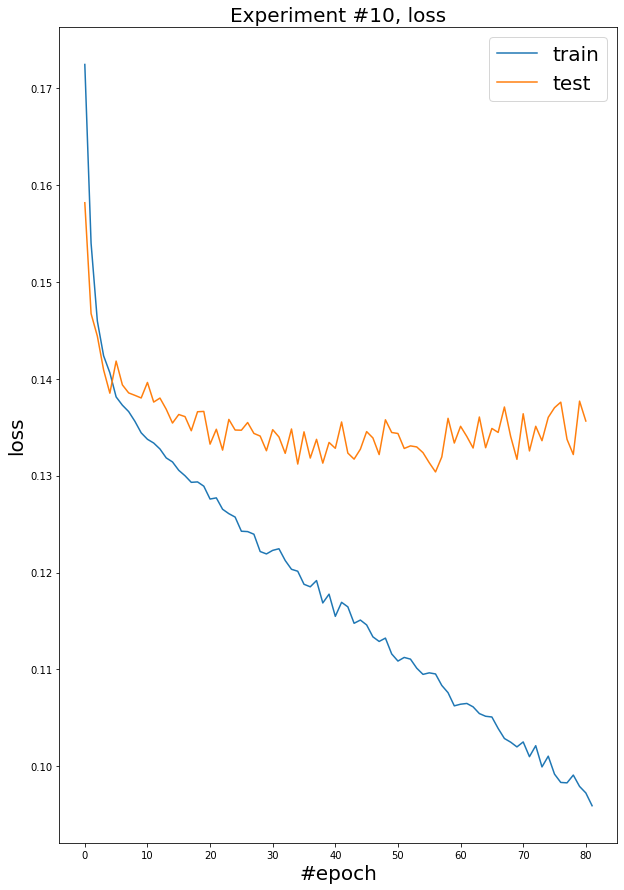

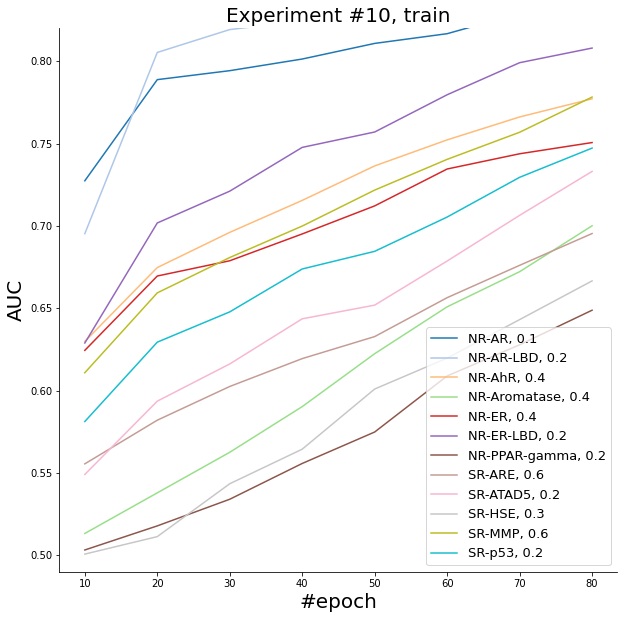

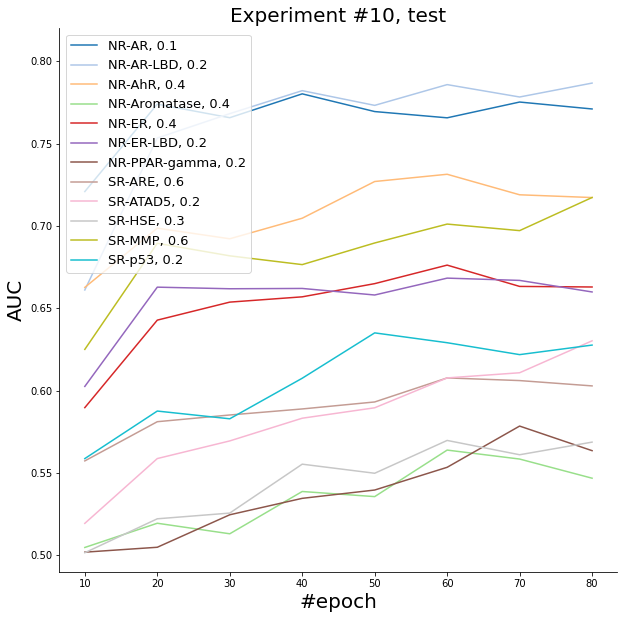

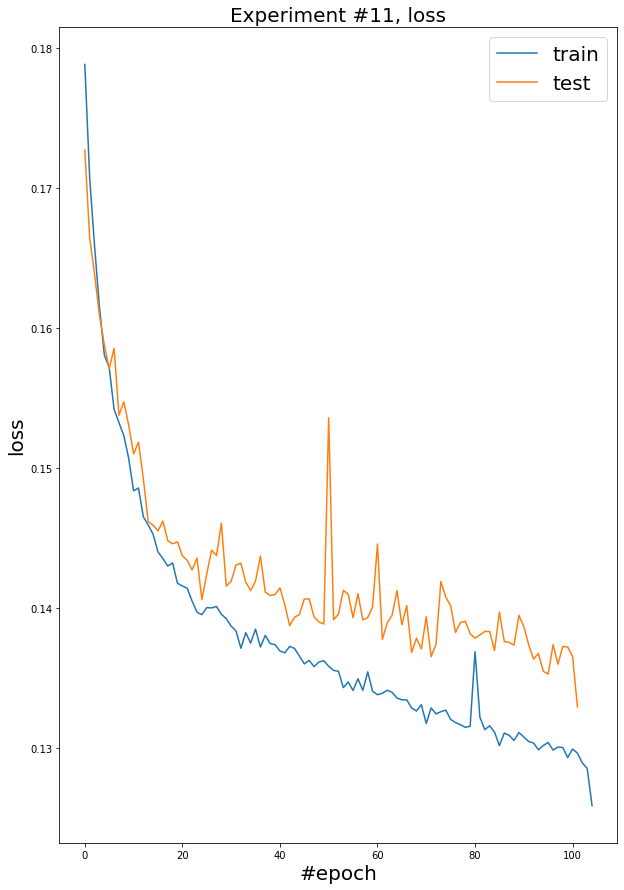

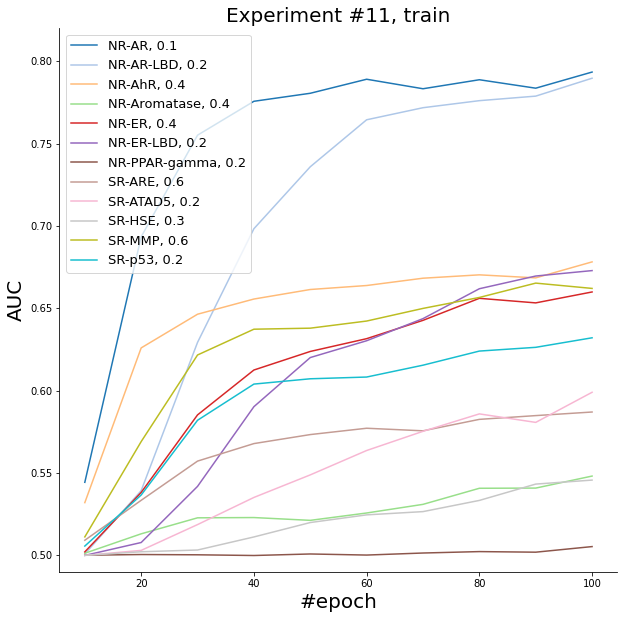

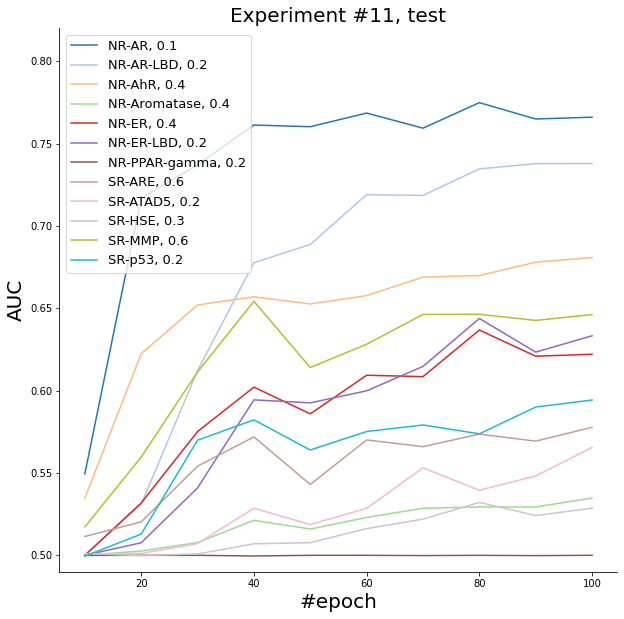

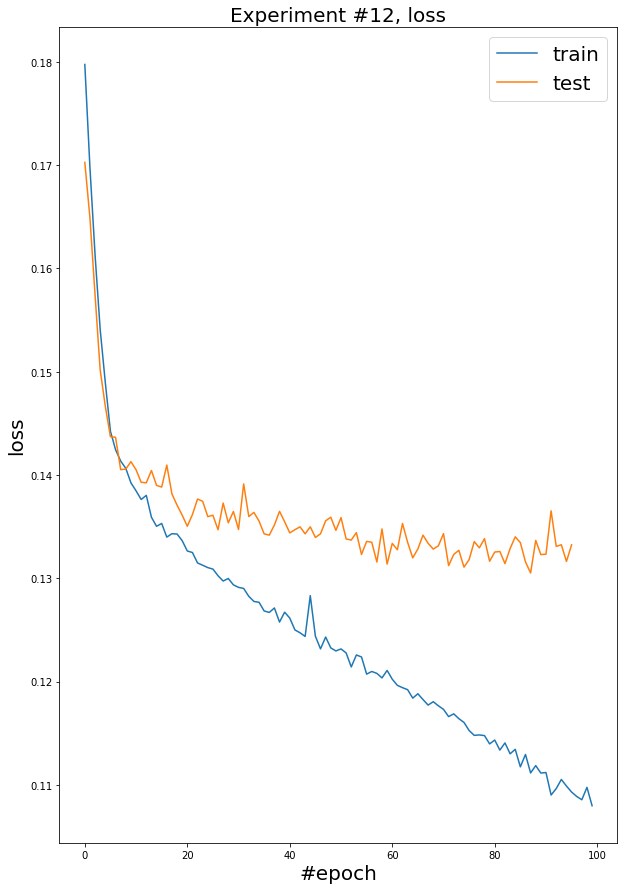

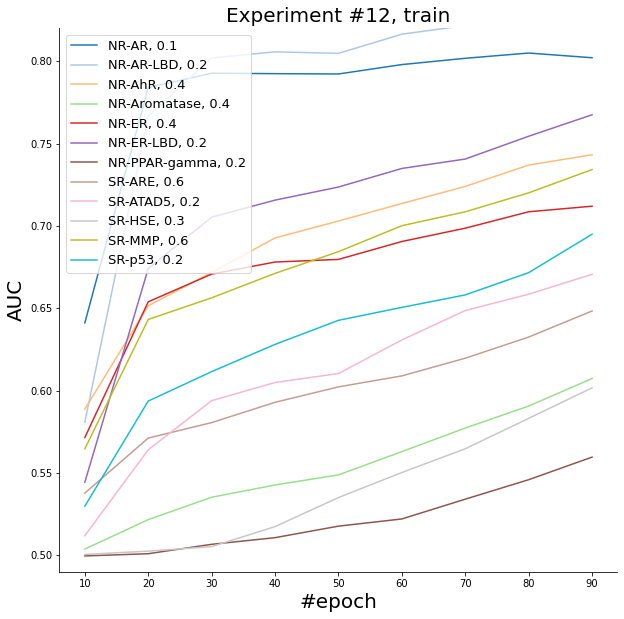

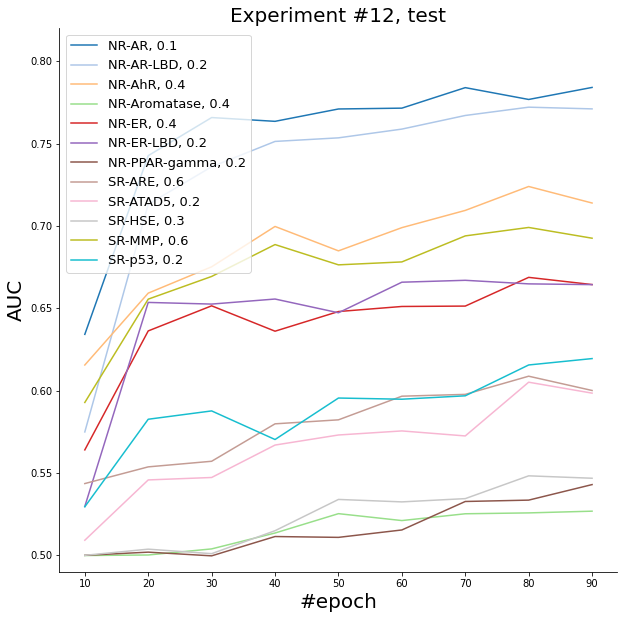

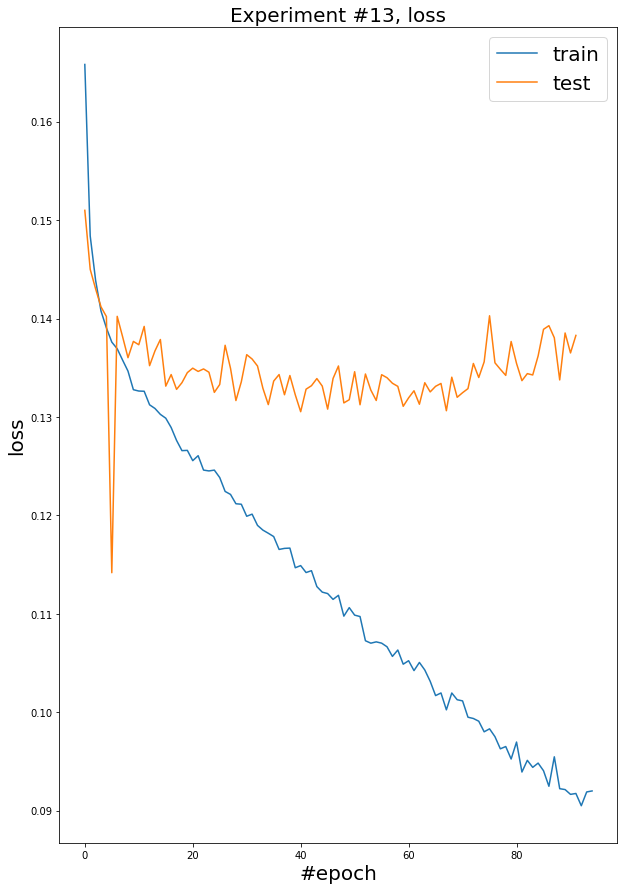

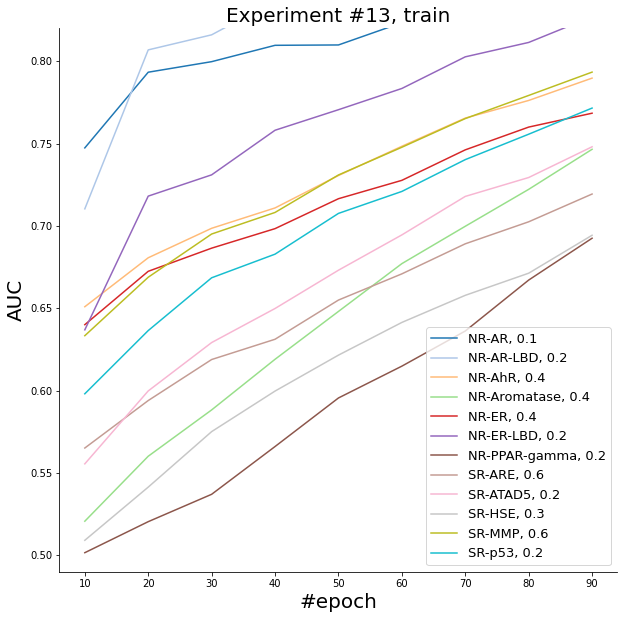

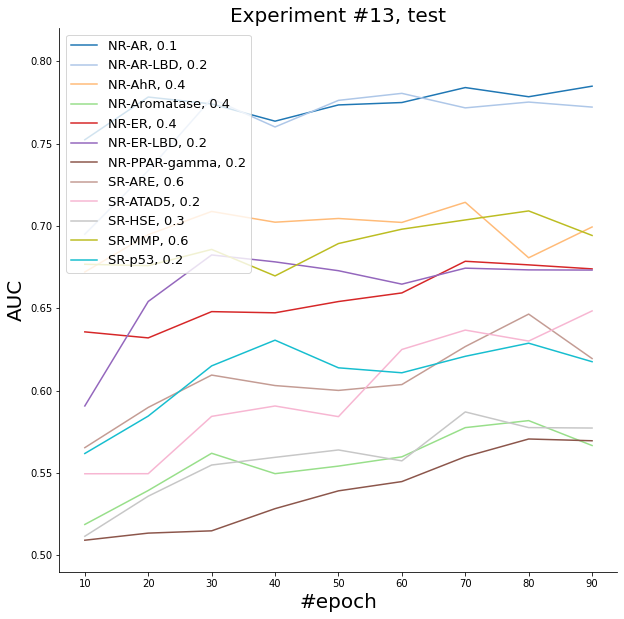

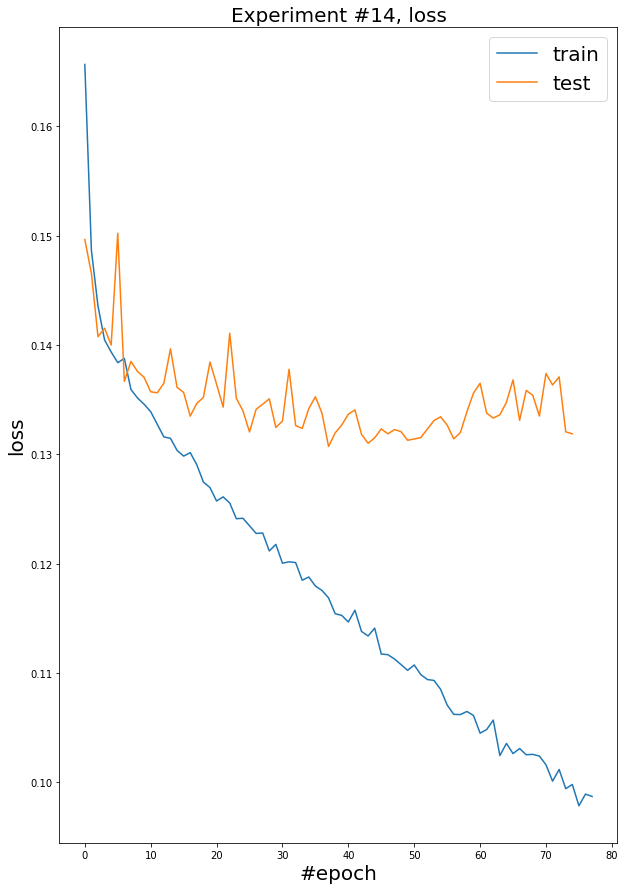

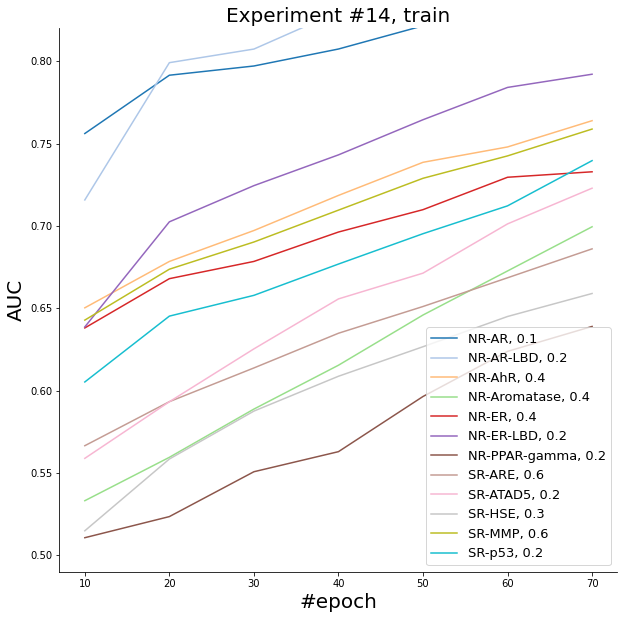

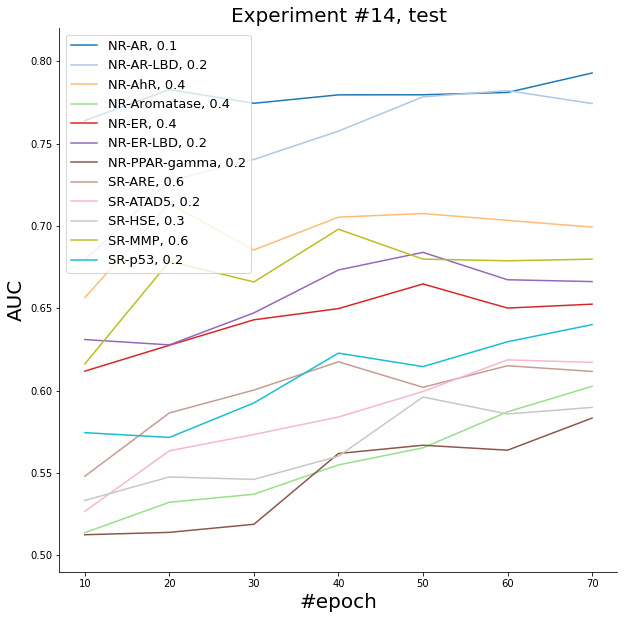

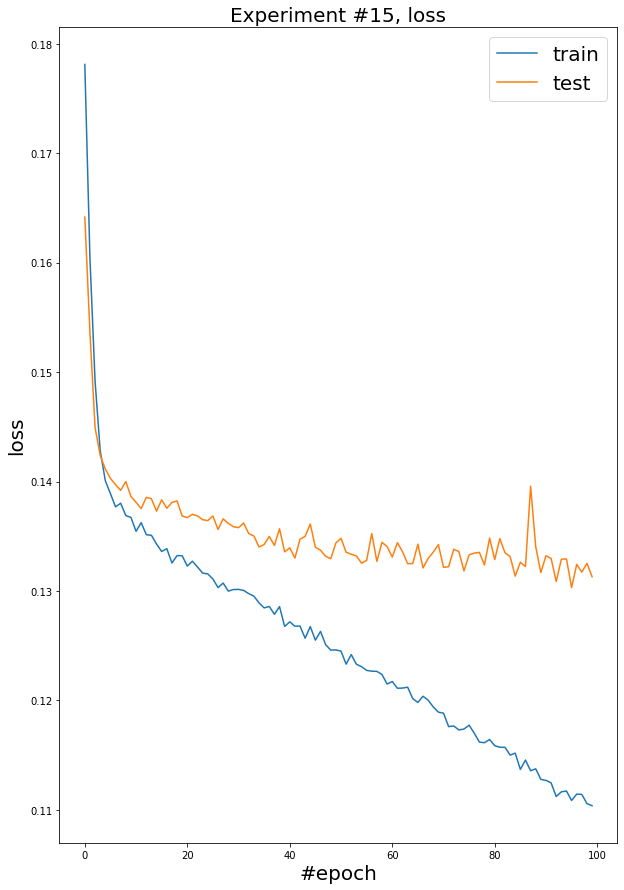

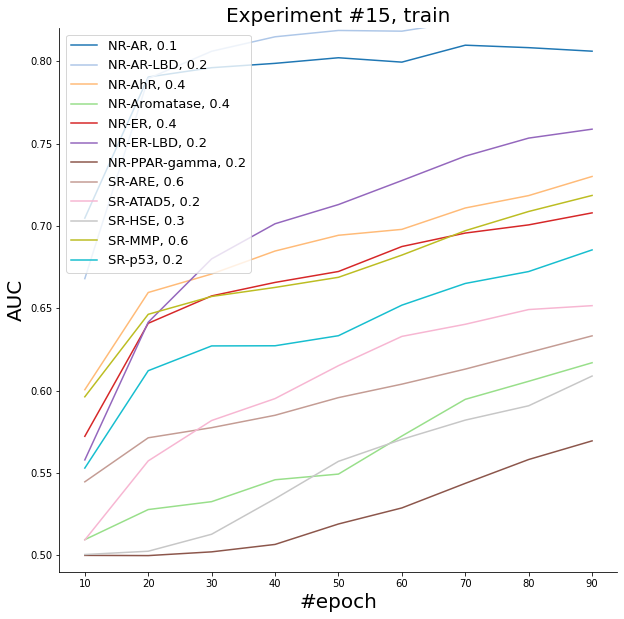

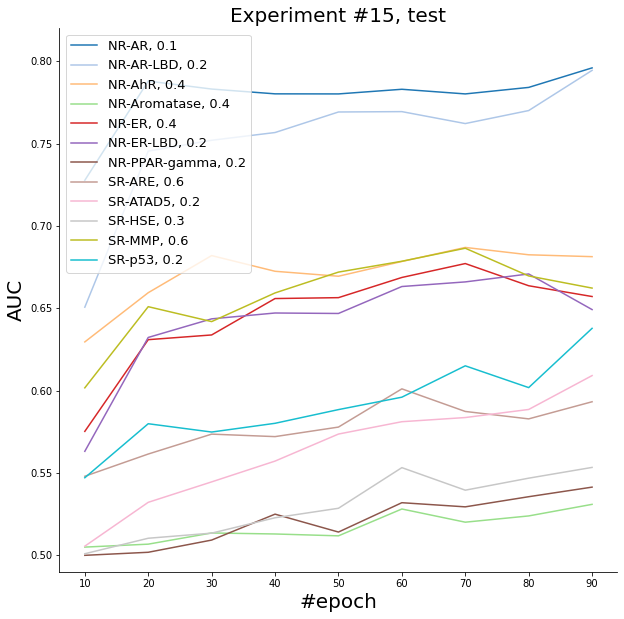

In [32]:
folder_plot_channels(data_folder,[10,11,12,13,14,15],smooth = 10)

Experiment # 10 train   loss  is  0.1
Experiment # 10 test   loss  is  0.14
0.7498383751214254
0.654553284947407
Experiment # 11 train   loss  is  0.13
Experiment # 11 test   loss  is  0.13
0.6394204728299812
0.6155815137441222
Experiment # 12 train   loss  is  0.11
Experiment # 12 test   loss  is  0.13
0.6976684457369432
0.6437220589683307
Experiment # 13 train   loss  is  0.09
Experiment # 13 test   loss  is  0.14
0.7713540403016744
0.6580278270493124
Experiment # 14 train   loss  is  0.1
Experiment # 14 test   loss  is  0.13
0.7397669960373471
0.6591089240751503
Experiment # 15 train   loss  is  0.11
Experiment # 15 test   loss  is  0.13
0.693191694141659
0.6421671623208038


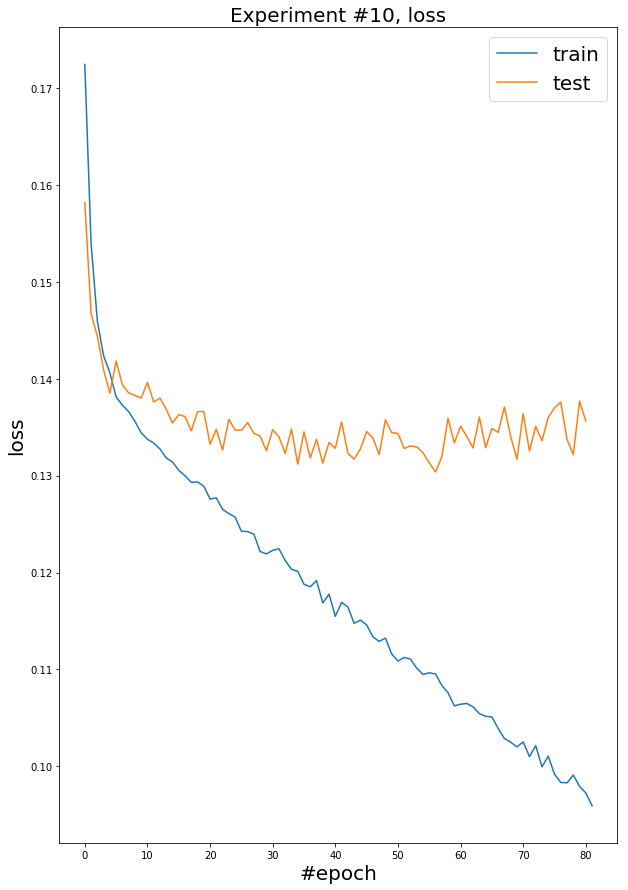

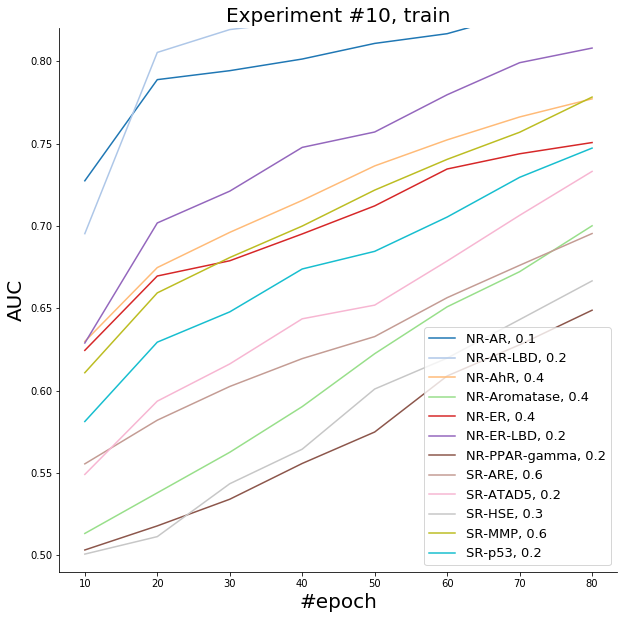

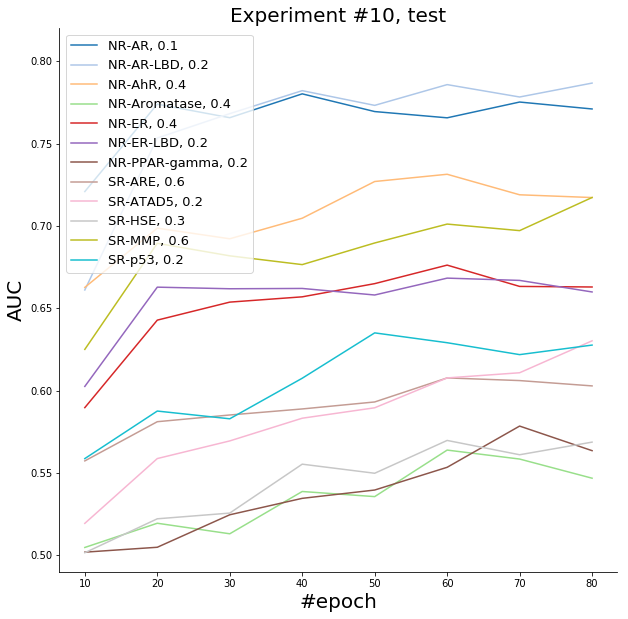

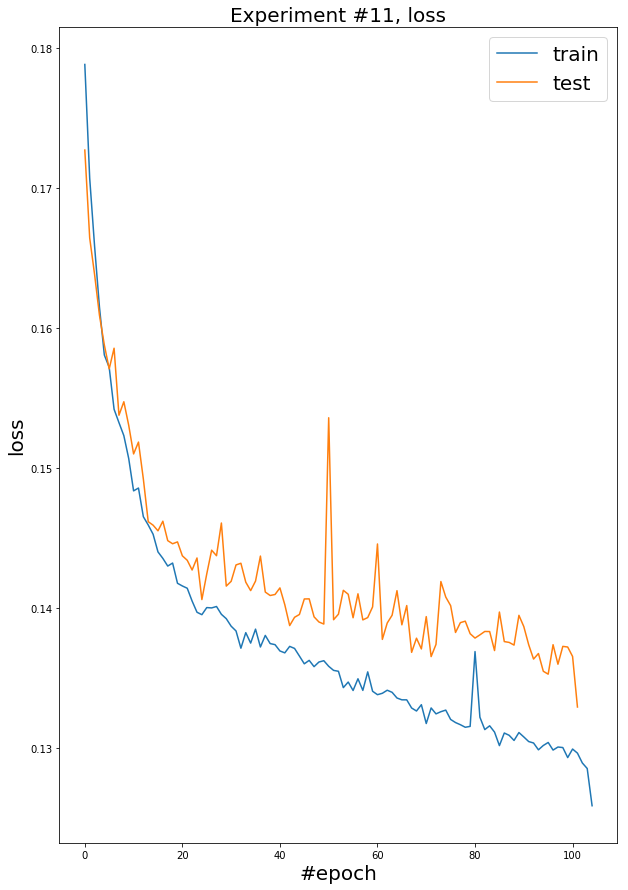

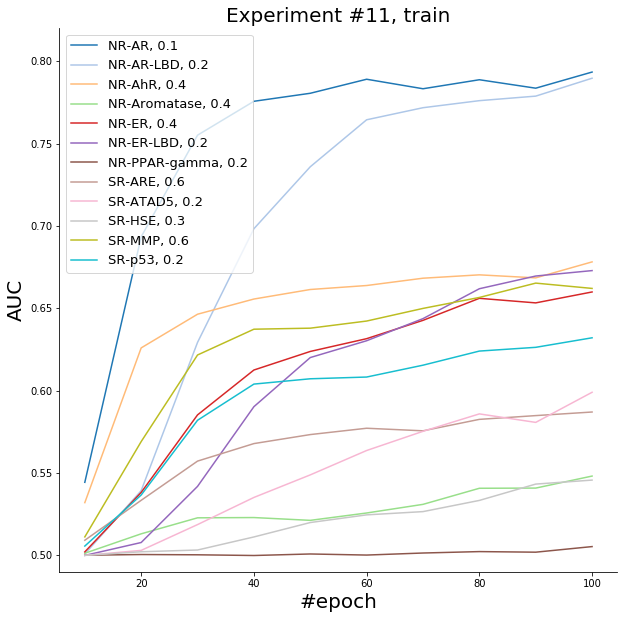

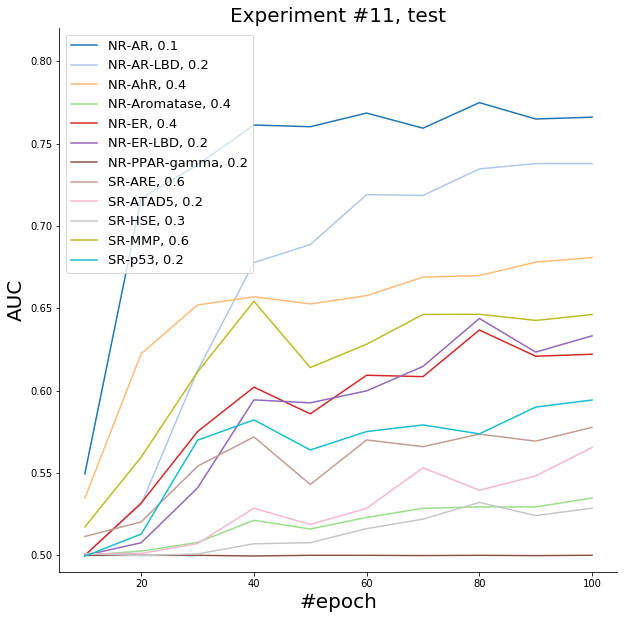

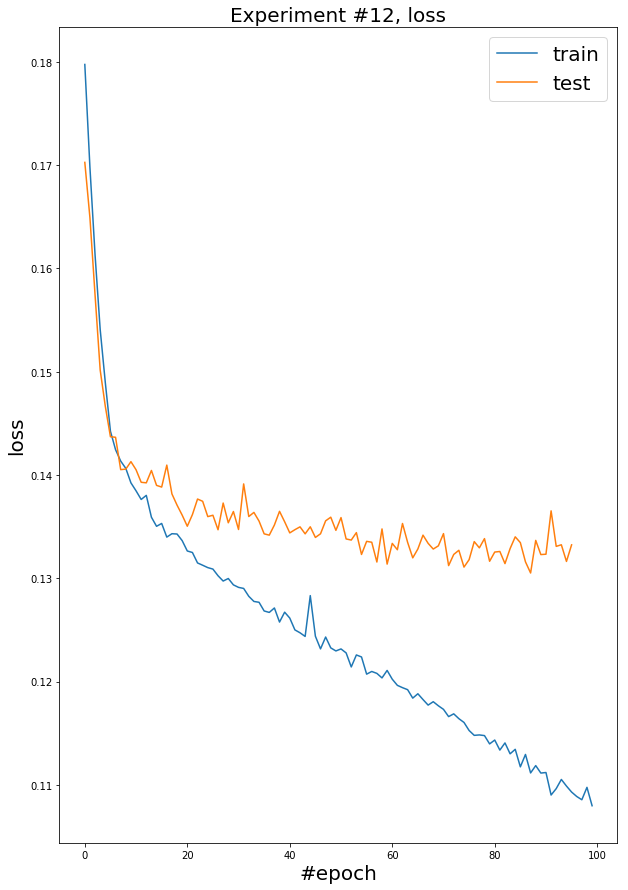

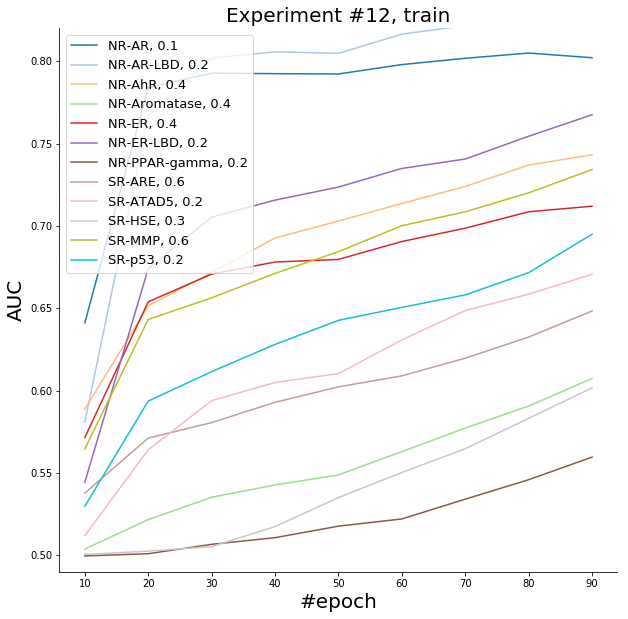

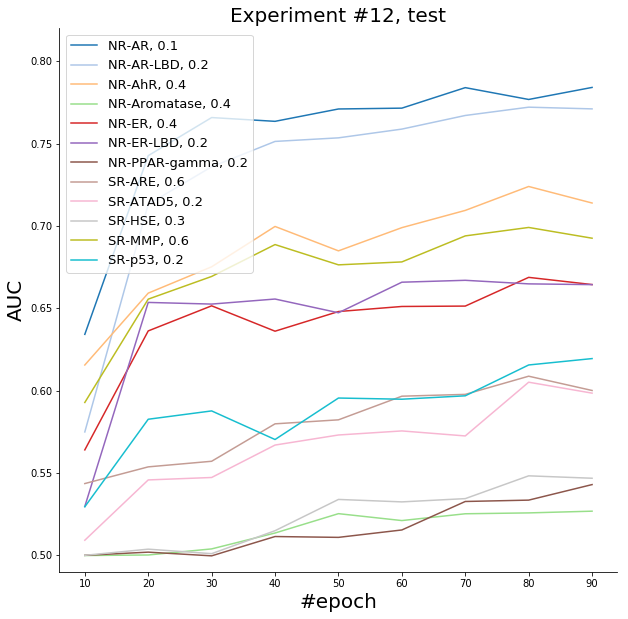

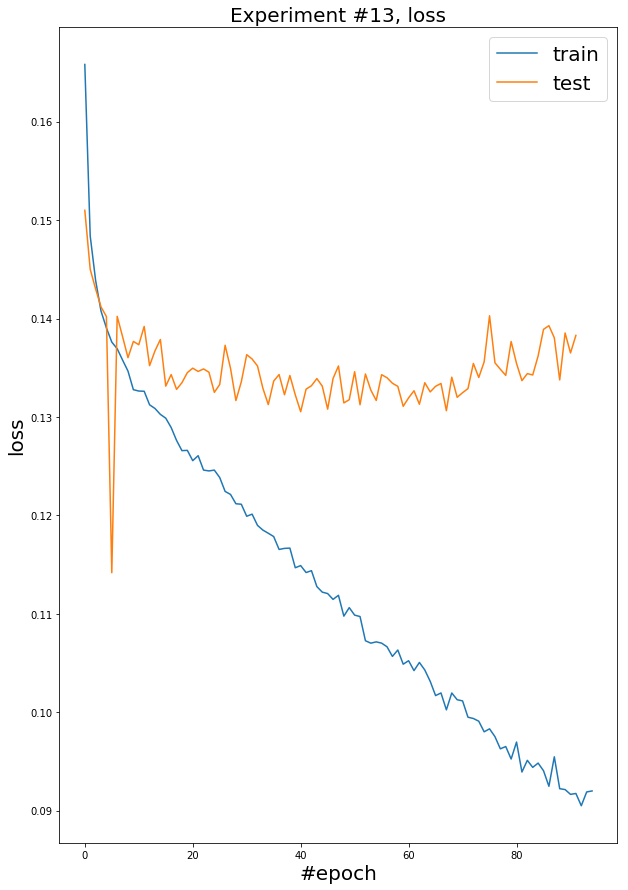

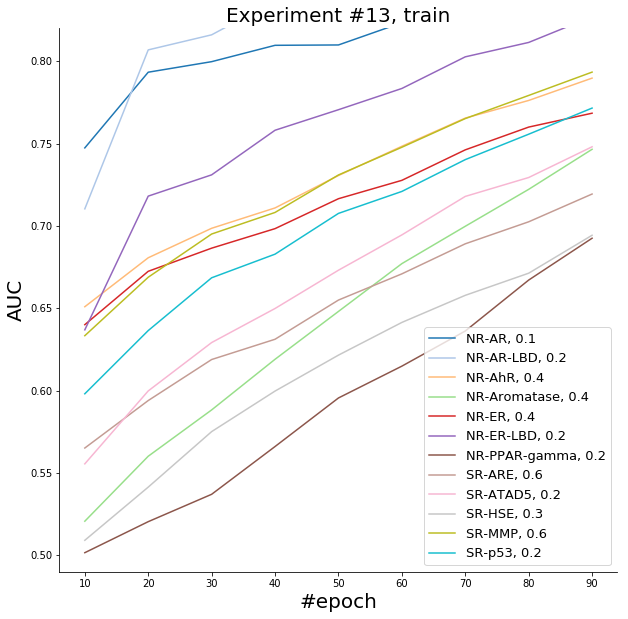

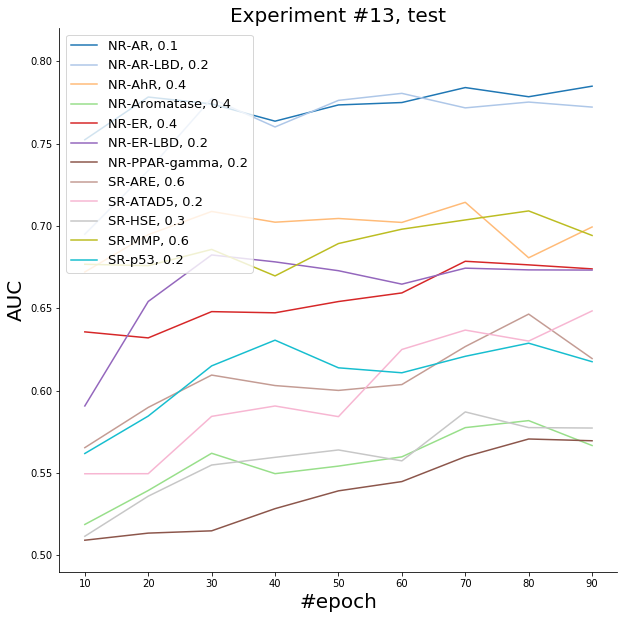

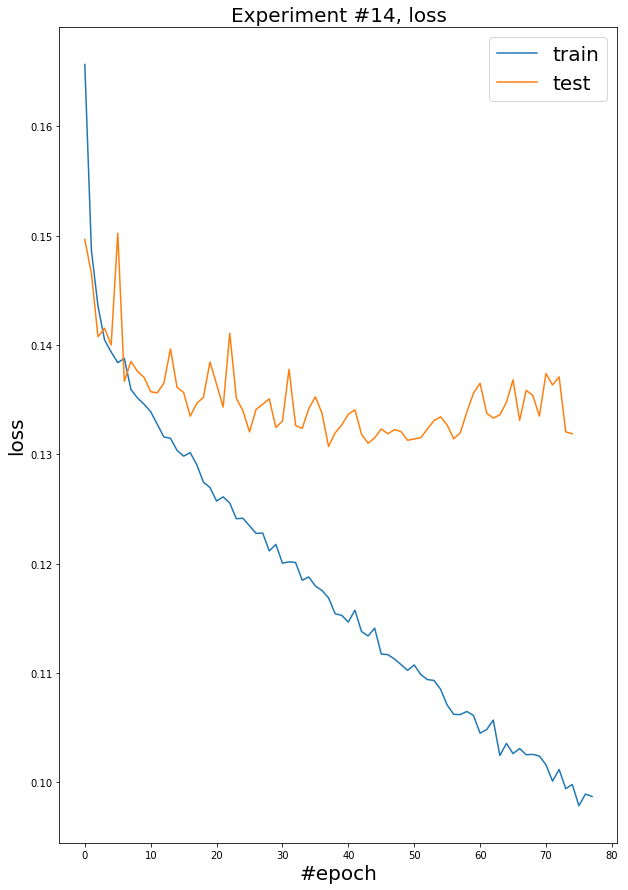

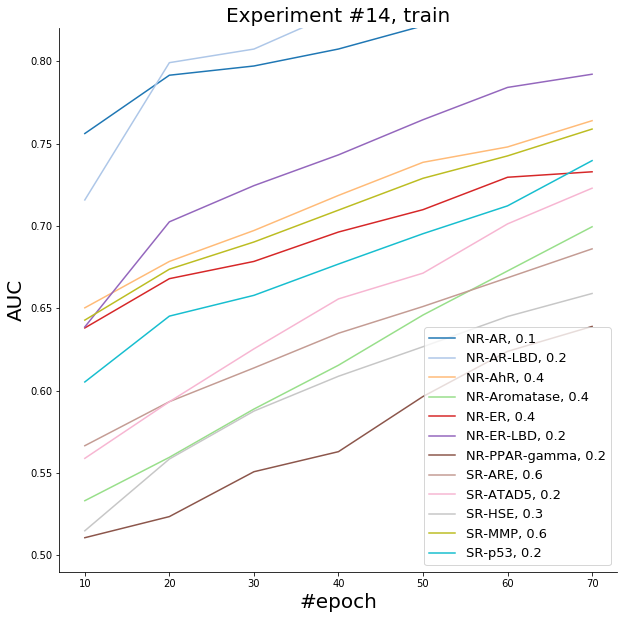

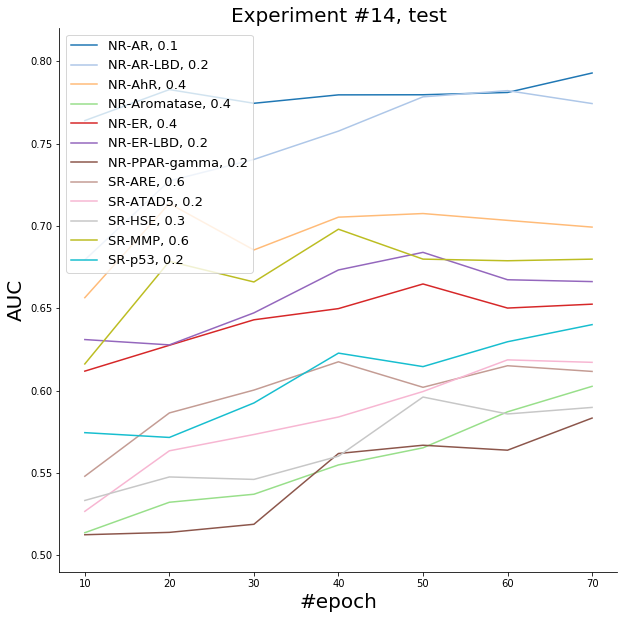

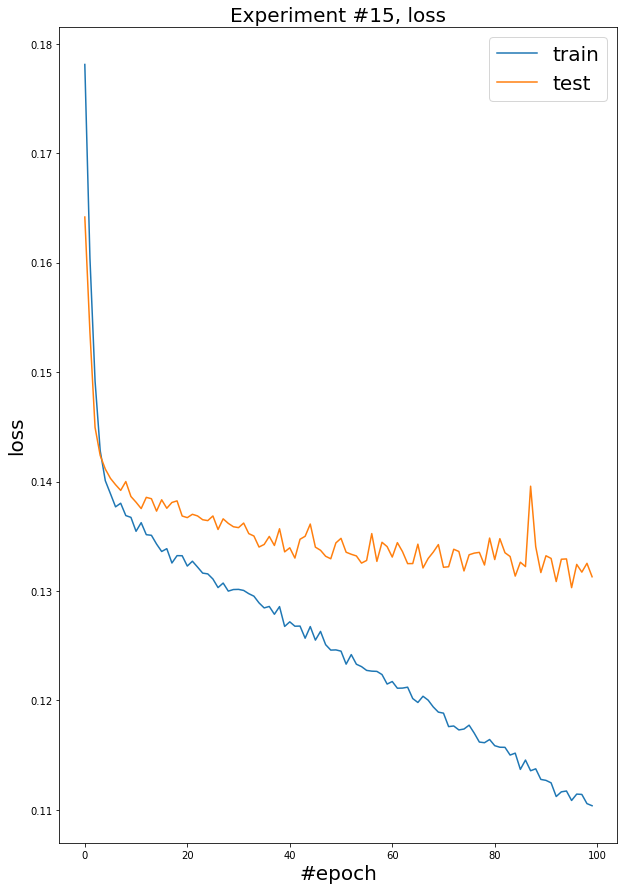

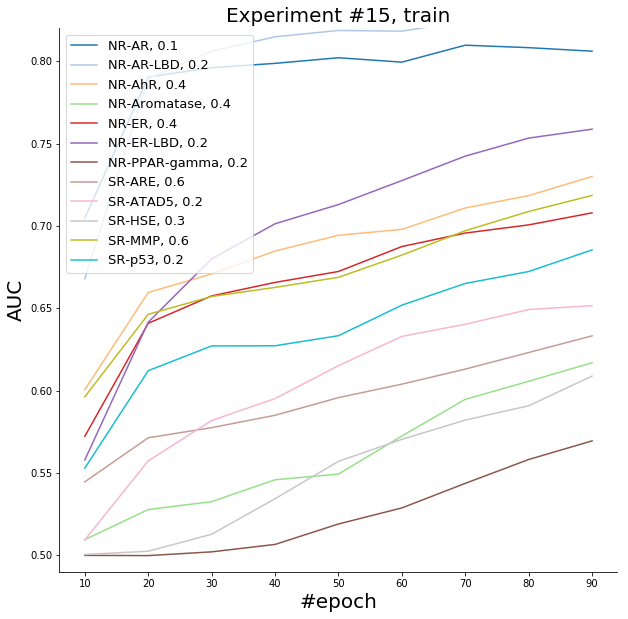

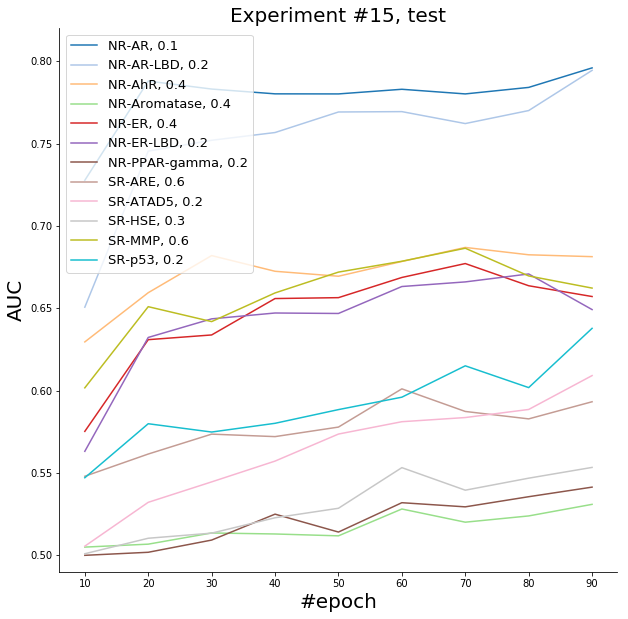

In [17]:
folder_plot_channels(data_folder,[10,11,12,13,14,15],smooth = 10)

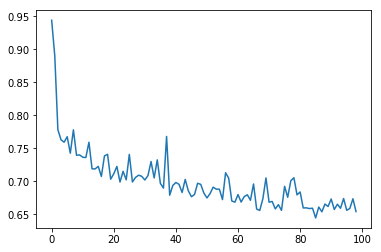

In [45]:
plot_plain_graph('log_test_loss.txt')

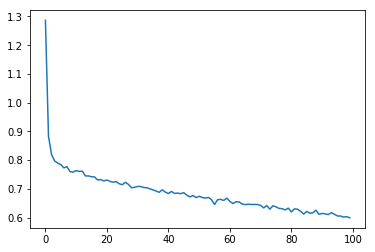

In [46]:
plot_plain_graph('log_train_loss.txt')

In [43]:
with open('log_history.txt','r') as f:
    data = f.read()
    print(data)

Using device: cuda

GeForce GTX 1080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Start loading dataset...
Initial dataset size =  7347
Post-processed dataset size =  7347
Dataset has been loaded
Neural network initialization...
Net(
  (conv1): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=12, bias=True)
  (convolution): Sequ

In [17]:
from torch import nn
# number of conformers created for every molecule
global NUM_CONFS
NUM_CONFS = 100

# amount of chemical elements taking into account
global AMOUNT_OF_ELEM
AMOUNT_OF_ELEM = 6

# size of batch
global BATCH_SIZE
BATCH_SIZE = 16 

# dimension of voxel with conformer
global VOXEL_DIM
VOXEL_DIM = 70

# amount of target values
global TARGET_NUM
TARGET_NUM = 12

#dataset folder
global DATASET_PATH
DATASET_PATH="./Documents/MultiTox/database"

#logs path
global LOG_PATH
LOG_PATH="./Documents/MultiTox/logs"

#models path
global MODEL_PATH
MODEL_PATH="./Documents/MultiTox/models"

#number of epochs
global EPOCHS_NUM
EPOCHS_NUM=100

#loss penalty
global PENALTY
PENALTY = torch.FloatTensor([0.1,0.2,0.4,0.4,0.4,0.2,0.2,0.6,0.2,0.3,0.6,0.2])

#patience for early stopping
global PATIENCE
PATIENCE = 25

#sigma parameter for preprocessing
global SIGMA
SIGMA = 7


NameError: name 'torch' is not defined

In [18]:
# create neural net
class Net(nn.Module):
    def __init__(self, dim=70, num_elems=6, num_targets=12, batch_size=BATCH_SIZE):
        super(Net, self).__init__()

        # initialize dimensions
        self.dim = dim
        self.num_elems = num_elems
        self.num_targets = num_targets
        self.batch_size = batch_size

        # create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3, 3, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 1)

        # initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)

        self.convolution = nn.Sequential(
            self.conv1,
            self.pool1,
            nn.ReLU(),
            self.conv2,
            self.pool2,
            nn.ReLU(),
            self.conv3,
            self.pool3,
            nn.ReLU(),
            self.conv4,
            self.pool4,
            nn.ReLU()
        )

        def weights_init(m):
            if type(m) == nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        # initialize convolutional layers' weights
        self.convolution.apply(weights_init)

    def forward(self, x):
        x_conv = self.convolution(x)
        x_vect = x_conv.view(x.shape[0], -1)
        y1 = F.relu(self.fc1(x_vect))
        y2=self.fc2(y1)
        #         multi-label (not multi-class!) classification => sigmoid non-linearity
        return y2

In [20]:
model=Net()

In [35]:
for parameter in model.parameters():
    print(parameter.detach().numpy().flatten().shape)

(5184,)
(32,)
(55296,)
(64,)
(221184,)
(128,)
(884736,)
(256,)
(2097152,)
(1024,)
(1024,)
(1,)


In [36]:
sum([parameter.detach().numpy().flatten().shape[0] for parameter in model.parameters()])

3266081